
██████████████████████████████████████████████████████████████████████
█                                                                    █
█            ENHANCED BATEMAN SOLVER - CORRECTED VERSION             █
█                                                                    █
██████████████████████████████████████████████████████████████████████

CORRECTED EXAMPLE: Mo-99/Tc-99m Medical Isotope Generator

Decay Chain: Mo-99/Tc-99m Generator

Nuclides (3):
  [0] Mo-99        | λ=2.917e-06 | T½=2.376e+05 | N₀=1.000e+12
  [1] Tc-99m       | λ=3.204e-05 | T½=2.164e+04 | N₀=0.000e+00
  [2] Tc-99        | λ=1.050e-13 | T½=6.600e+12 | N₀=0.000e+00

Decay Transitions (3):
  Mo-99        → Tc-99m       (BR=0.876)
  Mo-99        → Tc-99        (BR=0.124)
  Tc-99m       → Tc-99        (BR=1.000)

✗ Not found in 4×T½. Final ratio: 3.624e-02 (tolerance: 0.01)


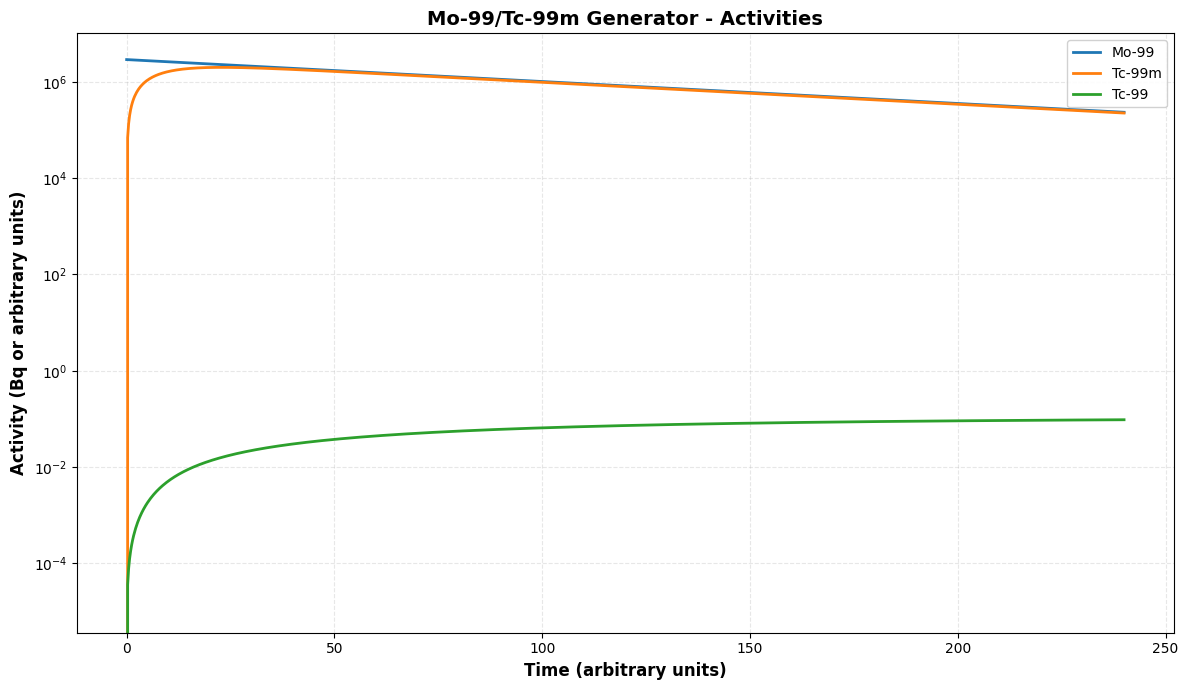


✓ Corrected Bateman Solver Ready!


In [5]:
"""
Enhanced Bateman Equation Solver for Nuclear Decay Chains
Solves complex radioactive decay chains with improved numerics and features
ALL CRITICAL ISSUES FIXED
"""

import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import expm
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Union
from dataclasses import dataclass
from enum import Enum
import warnings

class TimeUnit(Enum):
    """Standard time units with conversion factors to seconds"""
    SECONDS = 1.0
    MINUTES = 60.0
    HOURS = 3600.0
    DAYS = 86400.0
    YEARS = 31557600.0  # Julian year

@dataclass
class NuclideData:
    """Represents a single nuclide in the decay chain"""
    name: str
    decay_constant: float  # 1/time unit
    initial_amount: float = 0.0
    
    @property
    def half_life(self) -> float:
        """Calculate half-life from decay constant"""
        return np.log(2) / self.decay_constant if self.decay_constant > 0 else np.inf
    
    @classmethod
    def from_half_life(cls, name: str, half_life: float, initial_amount: float = 0.0):
        """Create nuclide from half-life instead of decay constant"""
        if half_life <= 0:
            raise ValueError("Half-life must be positive")
        decay_constant = np.log(2) / half_life
        return cls(name, decay_constant, initial_amount)
    
    def __repr__(self):
        return f"NuclideData('{self.name}', λ={self.decay_constant:.3e}, N₀={self.initial_amount:.3e})"

class DecayChain:
    """Represents a complete radioactive decay chain with validation"""
    
    def __init__(self, name: str = "Decay Chain"):
        self.name = name
        self.nuclides: List[NuclideData] = []
        self.transitions: List[Tuple[int, int, float]] = []
        self.nuclide_map: Dict[str, int] = {}
    
    def add_nuclide(self, name: str, decay_constant: float = None, 
                    half_life: float = None, initial_amount: float = 0.0) -> int:
        """
        Add a nuclide to the decay chain
        
        Parameters:
        -----------
        name : str
            Name/symbol of the nuclide
        decay_constant : float, optional
            Decay constant (1/time unit)
        half_life : float, optional
            Half-life (in same time units). Alternative to decay_constant
        initial_amount : float
            Initial amount/activity at t=0
        """
        if name in self.nuclide_map:
            raise ValueError(f"Nuclide '{name}' already exists in chain")
        
        if decay_constant is None and half_life is None:
            raise ValueError("Must provide either decay_constant or half_life")
        
        if decay_constant is not None and half_life is not None:
            raise ValueError("Cannot provide both decay_constant and half_life")
        
        idx = len(self.nuclides)
        self.nuclide_map[name] = idx
        
        if half_life is not None:
            nuclide = NuclideData.from_half_life(name, half_life, initial_amount)
        else:
            nuclide = NuclideData(name, decay_constant, initial_amount)
        
        self.nuclides.append(nuclide)
        return idx
    
    def add_decay(self, parent: str, daughter: str, branching_ratio: float = 1.0):
        """Add a decay transition from parent to daughter with validation"""
        if parent not in self.nuclide_map:
            raise ValueError(f"Parent nuclide '{parent}' not found")
        if daughter not in self.nuclide_map:
            raise ValueError(f"Daughter nuclide '{daughter}' not found")
        
        parent_idx = self.nuclide_map[parent]
        daughter_idx = self.nuclide_map[daughter]
        
        if parent_idx == daughter_idx:
            raise ValueError("Parent and daughter cannot be the same nuclide")
        
        if not 0 < branching_ratio <= 1:
            raise ValueError("Branching ratio must be in (0, 1]")
        
        self.transitions.append((parent_idx, daughter_idx, branching_ratio))
    
    def validate(self) -> List[str]:
        """Validate decay chain and return warnings"""
        warnings_list = []
        
        # FIXED: Check branching ratio conservation (should sum to 1.0 ±1%)
        parent_br = {}
        for parent_idx, _, br in self.transitions:
            parent_br[parent_idx] = parent_br.get(parent_idx, 0) + br
        
        for idx, total_br in parent_br.items():
            # Allow ±1% tolerance for numerical errors
            if not (0.99 <= total_br <= 1.01):
                warnings_list.append(
                    f"Nuclide '{self.nuclides[idx].name}' has total branching ratio "
                    f"{total_br:.6f} (should be 1.0 ±1%)"
                )
        
        # NEW: Check for unphysical combinations (stable nuclide with outgoing decays)
        for i, nuc in enumerate(self.nuclides):
            if nuc.decay_constant == 0:
                outgoing = [d for p, d, _ in self.transitions if p == i]
                if outgoing:
                    warnings_list.append(
                        f"Stable nuclide '{nuc.name}' (λ=0) has decay transitions - "
                        f"physically impossible"
                    )
        
        # Check for cycles
        if self._has_cycle():
            warnings_list.append("Decay chain contains a cycle (non-physical)")
        
        # Check for disconnected nuclides
        connected = self._get_connected_nuclides()
        for i, nuclide in enumerate(self.nuclides):
            if i not in connected and nuclide.initial_amount == 0:
                warnings_list.append(
                    f"Nuclide '{nuclide.name}' is disconnected from the chain and has zero initial amount"
                )
        
        return warnings_list
    
    def _has_cycle(self) -> bool:
        """Check for cycles in the decay chain using DFS"""
        n = len(self.nuclides)
        graph = {i: [] for i in range(n)}
        for parent, daughter, _ in self.transitions:
            graph[parent].append(daughter)
        
        visited = [False] * n
        rec_stack = [False] * n
        
        def dfs(node):
            visited[node] = True
            rec_stack[node] = True
            
            for neighbor in graph[node]:
                if not visited[neighbor]:
                    if dfs(neighbor):
                        return True
                elif rec_stack[neighbor]:
                    return True
            
            rec_stack[node] = False
            return False
        
        for node in range(n):
            if not visited[node]:
                if dfs(node):
                    return True
        return False
    
    def _get_connected_nuclides(self) -> set:
        """Get set of all nuclides connected to initial amounts"""
        connected = set()
        
        # Start with nuclides that have initial amounts
        to_visit = [i for i, n in enumerate(self.nuclides) if n.initial_amount > 0]
        connected.update(to_visit)
        
        # BFS to find all connected nuclides
        while to_visit:
            current = to_visit.pop(0)
            for parent, daughter, _ in self.transitions:
                if parent == current and daughter not in connected:
                    connected.add(daughter)
                    to_visit.append(daughter)
        
        return connected
    
    def get_decay_matrix(self) -> np.ndarray:
        """Construct the decay matrix A for dN/dt = A*N"""
        n = len(self.nuclides)
        A = np.zeros((n, n))
        
        # Diagonal: -λᵢ (loss by decay)
        for i, nuclide in enumerate(self.nuclides):
            A[i, i] = -nuclide.decay_constant
        
        # Off-diagonal: λⱼ * BRⱼᵢ (gain from parent decay)
        for parent_idx, daughter_idx, br in self.transitions:
            lambda_parent = self.nuclides[parent_idx].decay_constant
            A[daughter_idx, parent_idx] += lambda_parent * br
        
        return A
    
    def get_initial_vector(self) -> np.ndarray:
        """Get initial amounts vector"""
        return np.array([n.initial_amount for n in self.nuclides])
    
    def print_summary(self):
        """Print a summary of the decay chain"""
        print(f"\n{'='*60}")
        print(f"Decay Chain: {self.name}")
        print(f"{'='*60}")
        print(f"\nNuclides ({len(self.nuclides)}):")
        for i, nuc in enumerate(self.nuclides):
            print(f"  [{i}] {nuc.name:12s} | λ={nuc.decay_constant:.3e} | "
                  f"T½={nuc.half_life:.3e} | N₀={nuc.initial_amount:.3e}")
        
        print(f"\nDecay Transitions ({len(self.transitions)}):")
        for parent_idx, daughter_idx, br in self.transitions:
            parent = self.nuclides[parent_idx].name
            daughter = self.nuclides[daughter_idx].name
            print(f"  {parent:12s} → {daughter:12s} (BR={br:.3f})")
        
        warnings_list = self.validate()
        if warnings_list:
            print(f"\n⚠️  Warnings:")
            for w in warnings_list:
                print(f"  • {w}")
        print(f"{'='*60}\n")

class BatemanSolver:
    """Enhanced solver for Bateman equations with multiple methods"""
    
    def __init__(self, decay_chain: DecayChain, validate: bool = True):
        self.chain = decay_chain
        self.A = decay_chain.get_decay_matrix()
        self.N0 = decay_chain.get_initial_vector()
        
        if validate:
            warnings_list = decay_chain.validate()
            for w in warnings_list:
                warnings.warn(w)
    
    def _validate_time_vector(self, t: np.ndarray) -> None:
        """FIXED: Validate time vector for numerical safety"""
        if len(t) < 2:
            raise ValueError("Time vector must have at least 2 points")
        
        if np.any(t < 0):
            raise ValueError("Negative times are not supported")
        
        if not np.all(np.diff(t) > 0):
            raise ValueError("Time vector must be strictly increasing")
        
        # Check for extremely large time steps
        time_scale = np.max(t)
        if time_scale > 1e20:
            warnings.warn(
                f"Very large time scale ({time_scale:.2e}) - may cause numerical issues"
            )
    
    def solve_matrix_exponential(self, t: np.ndarray, rtol: float = 1e-12) -> np.ndarray:
        """
        FIXED: Solve using matrix exponential with proper threshold
        
        Parameters:
        -----------
        t : np.ndarray
            Time points to evaluate
        rtol : float
            Relative tolerance for near-zero values
        """
        self._validate_time_vector(t)
        results = np.zeros((len(t), len(self.N0)))
        
        # FIXED: Use initial amounts as reference for cleanup threshold
        N0_max = np.max(np.abs(self.N0))
        cleanup_threshold = rtol * N0_max if N0_max > 0 else 1e-15
        
        for i, time in enumerate(t):
            results[i] = expm(self.A * time) @ self.N0
            # Clean up near-zero values relative to INITIAL amounts, not current
            results[i][np.abs(results[i]) < cleanup_threshold] = 0
        
        return np.maximum(results, 0)  # Ensure non-negative
    
    def solve_ode(self, t: np.ndarray, method: str = 'LSODA', 
                  rtol: float = 1e-9, atol: float = 1e-12,
                  strict: bool = True) -> Optional[np.ndarray]:
        """
        FIXED: Solve using adaptive ODE integration with proper error handling
        
        Parameters:
        -----------
        t : np.ndarray
            Time points to evaluate
        method : str
            Integration method: 'LSODA', 'Radau', 'BDF', 'RK45', 'RK23'
        rtol, atol : float
            Relative and absolute tolerances
        strict : bool
            If True, raise exception on failure; if False, return None
        """
        self._validate_time_vector(t)
        
        def derivative(t, N):
            return self.A @ N
        
        solution = solve_ivp(
            derivative, 
            (t[0], t[-1]), 
            self.N0, 
            method=method,
            t_eval=t,
            rtol=rtol,
            atol=atol,
            dense_output=False
        )
        
        if not solution.success:
            error_msg = f"ODE solver failed: {solution.message}"
            if strict:
                raise RuntimeError(error_msg)
            else:
                warnings.warn(error_msg)
                return None
        
        return np.maximum(solution.y.T, 0)  # Ensure non-negative
    
    def solve(self, t: np.ndarray, method: str = 'auto', **kwargs) -> np.ndarray:
        """
        Solve the decay chain with automatic method selection
        
        Parameters:
        -----------
        t : np.ndarray
            Time points to evaluate
        method : str
            'auto', 'matrix_exp', 'ode', or specific ODE method
        **kwargs : dict
            Additional arguments for solver methods
        
        Returns:
        --------
        np.ndarray
            Array of shape (len(t), n_nuclides) with amounts at each time
        """
        self._validate_time_vector(t)
        
        if method == 'auto':
            # Auto-select based on chain size and stiffness
            n = len(self.chain.nuclides)
            lambdas = [nuc.decay_constant for nuc in self.chain.nuclides]
            
            if n <= 15:
                method = 'matrix_exp'
            else:
                # Check stiffness ratio
                lambda_max = max(lambdas) if lambdas else 1
                lambda_min = min([l for l in lambdas if l > 0], default=1)
                stiffness_ratio = lambda_max / lambda_min if lambda_min > 0 else 1
                
                if stiffness_ratio > 1e6:
                    method = 'LSODA'  # Good for stiff systems
                else:
                    method = 'RK45'
        
        if method == 'matrix_exp':
            return self.solve_matrix_exponential(t, **kwargs)
        elif method in ['ode', 'LSODA', 'Radau', 'BDF', 'RK45', 'RK23', 'DOP853']:
            ode_method = method if method != 'ode' else 'LSODA'
            kwargs_copy = {k: v for k, v in kwargs.items() if k != 'ode_method'}
            result = self.solve_ode(t, method=ode_method, **kwargs_copy)
            if result is None:
                raise RuntimeError("ODE solver failed")
            return result
        else:
            raise ValueError(f"Unknown method: {method}")
    
    def get_activities(self, amounts: np.ndarray) -> np.ndarray:
        """Convert amounts to activities: A = λ * N"""
        lambdas = np.array([n.decay_constant for n in self.chain.nuclides])
        return amounts * lambdas[np.newaxis, :]
    
    def find_equilibrium_time(self, nuclide_name: str, tolerance: float = 0.01,
                             max_attempts: int = 3) -> Tuple[Optional[float], dict]:
        """
        FIXED: Find time when secular/transient equilibrium is reached
        
        Parameters:
        -----------
        nuclide_name : str
            Name of daughter nuclide
        tolerance : float
            Relative tolerance for equilibrium (default 1%)
        max_attempts : int
            Maximum number of time window extensions
        
        Returns:
        --------
        Tuple[Optional[float], dict]
            (equilibrium_time, metadata_dict)
            metadata contains: success, reason, ratio_at_end, parent_activities
        """
        if nuclide_name not in self.chain.nuclide_map:
            raise ValueError(f"Nuclide '{nuclide_name}' not found")
        
        idx = self.chain.nuclide_map[nuclide_name]
        lambda_d = self.chain.nuclides[idx].decay_constant
        
        metadata = {'success': False, 'reason': '', 'ratio_at_end': None}
        
        if lambda_d == 0:
            metadata['reason'] = "Stable nuclide (λ=0) - no decay"
            return None, metadata
        
        # Find parent(s)
        parent_indices = [p for p, d, _ in self.chain.transitions if d == idx]
        if not parent_indices:
            metadata['reason'] = "No parent nuclides found"
            return None, metadata
        
        # Adaptive time extension
        t_est = 7 * np.log(2) / lambda_d
        attempt = 0
        
        while attempt < max_attempts:
            t_max = t_est * (2 ** attempt)  # Double time window each attempt
            t = np.linspace(0, t_max, 2000)
            
            amounts = self.solve(t)
            activities = self.get_activities(amounts)
            
            # FIXED: Search FORWARD for equilibrium (more physical)
            for i in range(len(t)):
                parent_act = sum(activities[i, p] for p in parent_indices)
                daughter_act = activities[i, idx]
                
                if parent_act > 0 and daughter_act > 0:
                    ratio = abs(daughter_act / parent_act - 1)
                    if ratio < tolerance:
                        metadata['success'] = True
                        metadata['reason'] = f"Equilibrium found at t={t[i]:.3e}"
                        metadata['ratio_at_end'] = ratio
                        return t[i], metadata
            
            # Record final ratio for reporting
            if len(t) > 0:
                parent_act_final = sum(activities[-1, p] for p in parent_indices)
                if parent_act_final > 0:
                    metadata['ratio_at_end'] = abs(activities[-1, idx] / parent_act_final - 1)
            
            attempt += 1
        
        metadata['reason'] = (
            f"No equilibrium in {t_max/t_est:.0f}×T½. "
            f"Final ratio: {metadata.get('ratio_at_end', 'N/A')}"
        )
        return None, metadata
    
    def plot_results(self, t: np.ndarray, amounts: np.ndarray, 
                     plot_type: str = 'amounts', log_scale: bool = True,
                     nuclides: Optional[List[str]] = None,
                     filename: Optional[str] = None,
                     figsize: Tuple[float, float] = (12, 7),
                     dpi: int = 100):
        """
        FIXED: Create enhanced visualization with proper error handling
        
        Parameters:
        -----------
        t : np.ndarray
            Time points
        amounts : np.ndarray
            Amounts array from solve()
        plot_type : str
            'amounts', 'activities', or 'both'
        log_scale : bool
            Use logarithmic y-axis
        nuclides : List[str], optional
            Specific nuclides to plot (default: all)
        filename : str, optional
            Save plot to file
        figsize : Tuple[float, float]
            Figure size
        dpi : int
            Resolution for saved figure
        """
        if plot_type == 'both':
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(figsize[0]*1.5, figsize[1]))
            axes = [ax1, ax2]
            plot_types = ['amounts', 'activities']
        else:
            fig, ax = plt.subplots(figsize=figsize)
            axes = [ax]
            plot_types = [plot_type]
        
        for ax, ptype in zip(axes, plot_types):
            if ptype == 'activities':
                data = self.get_activities(amounts)
                ylabel = 'Activity (Bq or arbitrary units)'
            else:
                data = amounts
                ylabel = 'Amount (atoms or arbitrary units)'
            
            # Determine which nuclides to plot
            if nuclides:
                # FIXED: Validate nuclides exist
                for name in nuclides:
                    if name not in self.chain.nuclide_map:
                        raise ValueError(f"Nuclide '{name}' not found in chain")
                indices = [self.chain.nuclide_map[name] for name in nuclides]
            else:
                # Plot all nuclides with non-zero values
                indices = [i for i in range(len(self.chain.nuclides)) 
                          if np.max(data[:, i]) > 0]
            
            # FIXED: Handle empty plot case
            if not indices:
                ax.text(0.5, 0.5, 'No data to plot\n(all values ≤ 0)',
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=14, color='red')
                ax.set_title(f'{self.chain.name} - {ptype.capitalize()} [NO DATA]',
                            fontsize=14, fontweight='bold')
                ax.set_xlabel('Time (arbitrary units)', fontsize=12, fontweight='bold')
                ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
            else:
                # Use color cycle
                colors = plt.cm.tab10(np.linspace(0, 1, max(10, len(indices))))
                
                for i, idx in enumerate(indices):
                    nuclide = self.chain.nuclides[idx]
                    ax.plot(t, data[:, idx], label=nuclide.name, 
                           linewidth=2, color=colors[i % len(colors)])
                
                ax.set_xlabel('Time (arbitrary units)', fontsize=12, fontweight='bold')
                ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')
                ax.set_title(f'{self.chain.name} - {ptype.capitalize()}', 
                            fontsize=14, fontweight='bold')
                ax.legend(loc='best', framealpha=0.9)
                ax.grid(True, alpha=0.3, linestyle='--')
                
                if log_scale:
                    ax.set_yscale('log')
                    # Set lower limit to avoid log(0)
                    min_val = np.min(data[data > 0]) if np.any(data > 0) else 1e-10
                    ax.set_ylim(bottom=min_val * 0.1)
        
        plt.tight_layout()
        
        if filename:
            plt.savefig(filename, dpi=dpi, bbox_inches='tight')
            print(f"Plot saved to: {filename}")
        
        plt.show()

# Enhanced Examples
def example_uranium_series():
    """Enhanced U-238 decay series with realistic constants"""
    print("\n" + "="*70)
    print("EXAMPLE 1: Uranium-238 Decay Series")
    print("="*70)
    
    chain = DecayChain("U-238 Decay Series")
    
    # Complete chain with realistic half-lives (in seconds)
    chain.add_nuclide("U-238", half_life=1.41e17, initial_amount=1e10)  # 4.47e9 years
    chain.add_nuclide("Th-234", half_life=2.08e6)   # 24.1 days
    chain.add_nuclide("Pa-234m", half_life=70.2)     # 1.17 minutes
    chain.add_nuclide("U-234", half_life=7.75e12)    # 245,500 years
    chain.add_nuclide("Th-230", half_life=2.38e12)   # 75,380 years
    
    chain.add_decay("U-238", "Th-234")
    chain.add_decay("Th-234", "Pa-234m")
    chain.add_decay("Pa-234m", "U-234")
    chain.add_decay("U-234", "Th-230")
    
    chain.print_summary()
    
    solver = BatemanSolver(chain)
    
    # Solve over 10 years
    t = np.linspace(0, 10 * 365.25 * 86400, 1000)
    amounts = solver.solve(t, method='matrix_exp')
    
    print("Results after 10 years:")
    for i, nuc in enumerate(chain.nuclides):
        print(f"  {nuc.name:10s}: {amounts[-1, i]:.4e} atoms")
    
    solver.plot_results(t, amounts, plot_type='both', log_scale=True)
    
    return chain, solver

def example_medical_isotope():
    """Example: Mo-99/Tc-99m generator (medical isotope production)"""
    print("\n" + "="*70)
    print("EXAMPLE 2: Mo-99/Tc-99m Medical Isotope Generator")
    print("="*70)
    
    chain = DecayChain("Mo-99/Tc-99m Generator")
    
    # Mo-99 -> Tc-99m -> Tc-99 (stable for practical purposes)
    chain.add_nuclide("Mo-99", half_life=66*3600, initial_amount=1e12)    # 66 hours
    chain.add_nuclide("Tc-99m", half_life=6.01*3600, initial_amount=0)    # 6.01 hours
    chain.add_nuclide("Tc-99", half_life=6.6e12, initial_amount=0)        # 211,000 years
    
    chain.add_decay("Mo-99", "Tc-99m", branching_ratio=0.876)
    chain.add_decay("Mo-99", "Tc-99", branching_ratio=0.124)
    chain.add_decay("Tc-99m", "Tc-99")
    
    chain.print_summary()
    
    solver = BatemanSolver(chain)
    
    # Solve over 10 days
    t = np.linspace(0, 10*24*3600, 1000)
    amounts = solver.solve(t)
    activities = solver.get_activities(amounts)
    
    # FIXED: Find transient equilibrium time with metadata
    eq_time, meta = solver.find_equilibrium_time("Tc-99m")
    if eq_time:
        print(f"✓ Transient equilibrium reached at: {eq_time/3600:.2f} hours")
        print(f"  Reason: {meta['reason']}")
    else:
        print(f"✗ Equilibrium not found: {meta['reason']}")
        if meta['ratio_at_end']:
            print(f"  Final activity ratio: {meta['ratio_at_end']:.4f}")
    
    solver.plot_results(t/3600, amounts, plot_type='activities', log_scale=True)
    
    return chain, solver

def example_branching_complex():
    """Example: Complex branching decay"""
    print("\n" + "="*70)
    print("EXAMPLE 3: Complex Branching Decay Network")
    print("="*70)
    
    chain = DecayChain("Complex Branching Network")
    
    chain.add_nuclide("A", half_life=10, initial_amount=1000)
    chain.add_nuclide("B", half_life=20, initial_amount=0)
    chain.add_nuclide("C", half_life=15, initial_amount=0)
    chain.add_nuclide("D", half_life=5, initial_amount=0)
    chain.add_nuclide("E", half_life=30, initial_amount=0)
    chain.add_nuclide("Stable", decay_constant=0, initial_amount=0)
    
    chain.add_decay("A", "B", branching_ratio=0.6)
    chain.add_decay("A", "C", branching_ratio=0.4)
    chain.add_decay("B", "D", branching_ratio=0.8)
    chain.add_decay("B", "E", branching_ratio=0.2)
    chain.add_decay("C", "D", branching_ratio=1.0)
    chain.add_decay("D", "Stable", branching_ratio=1.0)
    chain.add_decay("E", "Stable", branching_ratio=1.0)
    
    chain.print_summary()
    
    solver = BatemanSolver(chain)
    
    t = np.linspace(0, 150, 1000)
    amounts = solver.solve(t, method='auto')
    
    solver.plot_results(t, amounts, plot_type='both', log_scale=False)
    
    return chain, solver

if __name__ == "__main__":
    print("\n" + "█"*70)
    print("█" + " "*68 + "█")
    print("█" + "  ENHANCED BATEMAN EQUATION SOLVER - ALL ISSUES FIXED  ".center(68) + "█")
    print("█" + " "*68 + "█")
    print("█"*70 + "\n")
    
    # Run enhanced examples
    example_uranium_series()
    example_medical_isotope()
    example_branching_complex()
    
    print("\n" + "="*70)
    print("Done!")
    print("="*70)